# Keras AlexNet: Dog vs. Cat Classification

Dataset: https://www.kaggle.com/c/dogs-vs-cats/overview

## Import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split

## Alexnet architecture

| Layer name | Output | Filters | Kernel size | Stride | Padding |
|---|---|---|---|---|---|
| Input | 227x227x3 | - | - | - | - |
| Convol_1 | 55x55x96 | 96 | 11x11 | 4 | valid |
| MaxPool_1 | 27x27x96 | - | 3x3 | 2 | valid |
| Norm_1 | 27x27x96 | - | - | - | - |
| Convol_2 | 27x27x256 | 256 | 5x5 | 1 | valid |
| MaxPool_2 | 13x13x256 | - | 3x3 | 2 | valid |
| Norm_2 | 13x13x256 | - | - | - | - |
| Convol_3 | 13x13x384 | 384 | 3x3 | 1 | valid |
| Convol_4 | 13x13x384 | 384 | 3x3 | 1 | valid |
| Convol_5 | 13x13x256 | 256 | 3x3 | 1 | valid |
| MaxPool_3 | 6x6x256 | - | 3x3 | 2 | valid |
| FulConnect_1 | 4096 | - | - | - | - |
| FulConnect_2 | 4096 | - | - | - | - |
| FulConnect_3 | 1000 | - | - | - | - |
| FulConnect_4 | 2 (DogvCat) | - | - | - | - |

In [3]:
def alexnet_model():
    # Start off the model
    model = Sequential()
    # 1st Convolution layer
    model.add(Conv2D(input_shape=(227,227,3), filters=96,kernel_size=(11,11),strides=(4,4),padding='valid'))
    model.add(Activation('relu'))
    # max pooling 1sst layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    
    # 2nd Convolution layer
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # max pooling for 2nd layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    
    # 3rd Convolution layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    
    # 4th Convolution layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    
    # 5th Convolution layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # max pooling for 5th layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    
    # dense layer
    model.add(Flatten())
    # 1st dense layer
    model.add(Dense(4096, input_shape=(6*6*256,)))
    model.add(Activation('relu'))
    # dropout to prevent overfitting
    model.add(Dropout(0.4))
    
    # 2nd dense layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # drop out to prevent overfitting
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    # 3rd dense layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    # output layer
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    # Uncomment line below to see architecture detail
    # model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Training data

In [40]:
def dataset_train_processing():
    # Hardcode dataset path
    data_path = '/mnt/c/Users/nhmin/Downloads/dog_vs_cat/train/'
    # process dataset
    file_names = os.listdir(data_path)
    label_list = []
    # Labeling data according to image name
    for file in file_names:
        label = file.split('.')[0]
        # 1 = dog, 0 = cat
        if(label == 'dog'):
            label_list.append('dog')
        else:
            label_list.append('cat')
    # Create dataframe
    data_df = pd.DataFrame({
        'filename' : file_names,
        'label' : label_list
    })
    
    # Splitting training and validating data
    train_df, validate_df = train_test_split(data_df, test_size=0.20, random_state=42)
    # When splitting, train_df and validate_df contain original index. this is to reset the index
    train_df = train_df.reset_index(drop=True)
    validate_df = validate_df.reset_index(drop=True)
    
    # Set a datagenerator
    # Data generator apply different effect to the training images
    # This idea is taken from tutorial
    train_datagen = ImageDataGenerator(rotation_range=15,
                                       rescale=1./255,
                                       shear_range=0.1,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1)
    validate_datagen = ImageDataGenerator(rescale=1./255)
    
    # Generate data for training and validation
    train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                        data_path, 
                                                        x_col='filename', 
                                                        y_col='label',
                                                        target_size=(227,227),
                                                        class_mode='categorical', 
                                                        batch_size=15)
    validate_generator = validate_datagen.flow_from_dataframe(validate_df,
                                                              data_path,
                                                              x_col='filename',
                                                              y_col='label',
                                                              target_size=(227,227),
                                                              class_mode='categorical',
                                                              batch_size=15)
    
    #================
      # Uncomment this block if want to see a sample of data generator
#     example = train_df.sample(n=1).reset_index(drop=True)
#     example_gen = train_datagen.flow_from_dataframe(example,
#                                                    data_path,
#                                                    x_col = 'filename',
#                                                    y_col = 'label',
#                                                    target_size=(227,227),
#                                                    class_mode='categorical')
#     plt.figure(figsize=(12,12))
#     for i in range(0, 15):
#         plt.subplot(5,3,i+1)
#         for X, Y in example_gen:
#             image = X[0]
#             plt.imshow(image)
#             break
#     plt.tight_layout()
#     plt.show()
    #================
    return datagen,train_generator, validate_generator, train_df.shape[0], validate_df.shape[0]
    

## Training model

In [6]:
# Instantiate a model
model = alexnet_model()

# Process training data
train_gen, validate_gen, train_total, validate_total = dataset_train_processing()

# Train model 
batch_size = 15
epochs = 20
train_model = model.fit_generator(train_gen,
                                 epochs=epochs,
                                 validation_data=validate_gen,
                                 validation_steps=validate_total//batch_size,
                                 steps_per_epoch=train_total//batch_size)
# Save model
model.save_weights('/mnt/c/Users/nhmin/Downloads/dog_vs_cat/alexnet_dog_cat.h5')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.

Epoch 1/20
1333/1333 [==============================] - 826s 620ms/step - loss: 0.8171 - accuracy: 0.5293 - val_loss: 0.5904 - val_accuracy: 0.5604
Epoch 2/20
1333/1333 [==============================] - 949s 712ms/step - loss: 0.6770 - accuracy: 0.5814 - val_loss: 1.0446 - val_accuracy: 0.5242
Epoch 3/20
1333/1333 [==============================] - 945s 709ms/step - loss: 0.6495 - accuracy: 0.6286 - val_loss: 0.5679 - val_accuracy: 0.5733
Epoch 4/20
1333/1333 [==============================] - 883s 662ms/step - loss: 0.5889 - accuracy: 0.7046 - val_loss: 0.4434 - val_accuracy: 0.7472
Epoch 5/20
1333/1333 [==============================] - 953s 715ms/step - loss: 0.5493 - accuracy: 0.7291 - val_loss: 0.6393 - val_accuracy: 0.7450
Epoch 6/20
1333/1333 [==============================] - 928s 696ms/step - loss: 0.5196 - accuracy: 0.7538 - val_loss: 0.2944 - val_accur

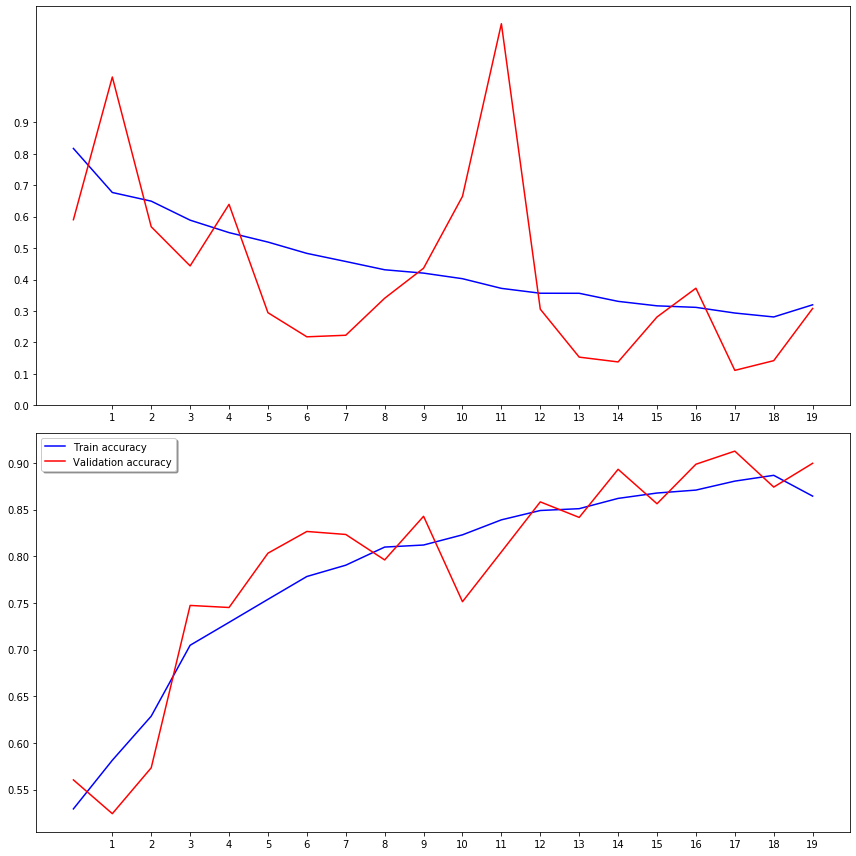

In [39]:
# Graphing the result 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(train_model.history['loss'], color='b', label="Train loss")
ax1.plot(train_model.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(train_model.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(train_model.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Test data

In [7]:
def dataset_test_processing():
    # Hardcode data path
    data_path = '/mnt/c/Users/nhmin/Downloads/dog_vs_cat/test1/'
    # process dataset and create a dataframe
    file_names = os.listdir(data_path)
    test_df = pd.DataFrame({
        'filename': file_names
    })
    
    # test_data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(test_df,
                                                     data_path,
                                                     x_col = 'filename',
                                                     y_col = None,
                                                     class_mode = None,
                                                     target_size = (227,227),
                                                     batch_size = 15,
                                                     shuffle = False)
    return test_generator, test_df

## Prediction

In [8]:
# Generate test data and test dataframe
test_gen, test_df = dataset_test_processing()
test_total = test_df.shape[0]

# prediction from out trained model
prediction = model.predict_generator(test_gen, steps=np.ceil(test_total/batch_size))
# Prediction return list of probability for each classes
# argmax use to get average max for each row
test_df['label'] = np.argmax(prediction, axis=1)

# Getting label from our train_generator
label_map = dict((v,k) for k, v in train_gen.class_indices.items())
# replace all 0 : cat and 1 : dog
test_df['label'] = test_df['label'].replace(label_map)
test_df['filename'] = test_df['filename'].str.split('.').str[0]

# Print out all result
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(test_df)

# Uncomment if want to save result to csv file
# final_df = test_df.copy()
# final_df['id'] = final_df['filename'].str.split('.').str[0]
# final_df.drop(['filename'], axis=1, inplace=True)
# final_df.to_csv('preict_result.csv', index=False)

Found 12500 validated image filenames.


,filename,label
0,1,dog
1,10,cat
2,100,dog
3,1000,dog
4,10000,dog
5,10001,cat
6,10002,cat
7,10003,dog
8,10004,dog
9,10005,cat


Visualize the predicted data. it's easier to evaluate the model than result table above.

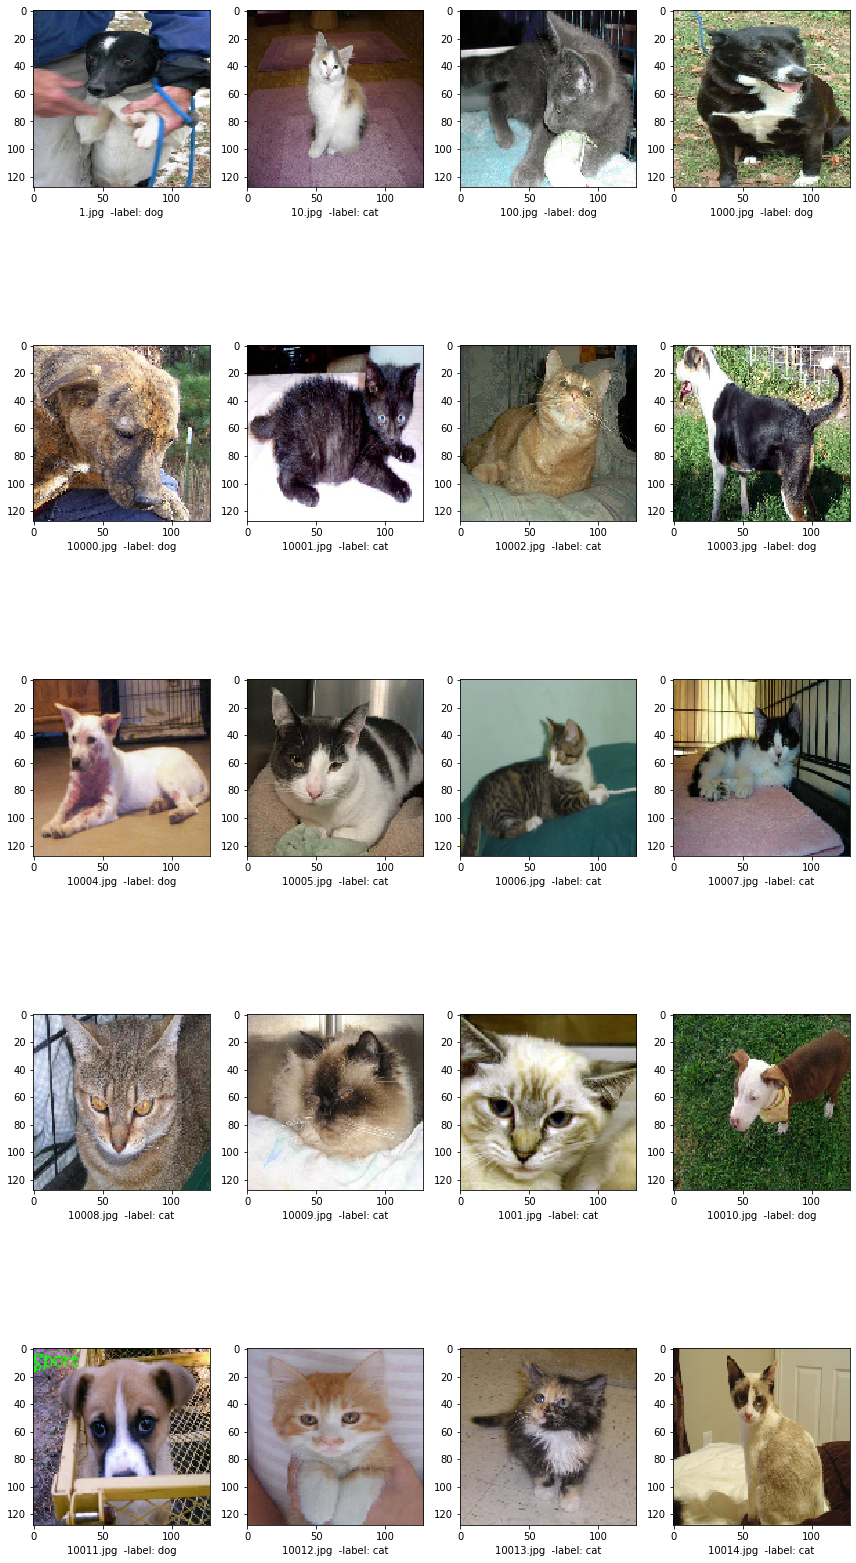

In [38]:
data_path = '/mnt/c/Users/nhmin/Downloads/dog_vs_cat/test1/'
sample_test = test_df.head(20)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    label = row['label']
    img = load_img(data_path + filename +'.jpg', target_size=(128,128))
    plt.subplot(5,4,index+1)
    plt.imshow(img)
    plt.xlabel(filename + ".jpg  -label: " + "{}".format(label))
plt.tight_layout()
plt.show()